In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe_statevars
import bmi_cfe_peturb

print(bmi_cfe_peturb)


<module 'bmi_cfe_peturb' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_peturb.py'>


In [2]:
cfe_instance = bmi_cfe_statevars.BMI_CFE() #one that changes state vars
cfe_peturbed = bmi_cfe_peturb.BMI_CFE()
#print("CFE")
print(cfe_instance.get_input_var_names())
#print()
print(cfe_peturbed.get_input_var_names())


['atmosphere_water__time_integral_of_precipitation_mass_flux', 'water_potential_evaporation_flux', 'state_var_change_soil', 'state_var_change_runoff', 'soil_reservoir', 'soil_reservoir_storage_deficit_m', 'surface_runoff_depth_m']
['atmosphere_water__time_integral_of_precipitation_mass_flux', 'water_potential_evaporation_flux', 'state_var_change_soil', 'state_var_change_runoff']


### This initialization function should perform all tasks that are to take place before entering the model’s time loop. Models should be refactored, if necessary, to read their inputs (which could include filenames for other input files) from a configuration file. BMI does not impose any constraint on how configuration files are formatted.

In [3]:
cfe_instance.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
cfe_peturbed.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
cfe_peturbed.forcing_file # path to forcing file



'./Forcing/cat58_01Dec2015.csv'

### Open the forcing file contained within the configuration file. We can run the model with any forcing. This is only an example. The path to the forcing file is contained within the configuration file, but it doesn't really need to be. This is just for organization.

In [4]:
with open(cfe_instance.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)

                 time  APCP_surface  DLWRF_surface  DSWRF_surface  \
0      12/1/2015 0:00           0.0     361.200012       0.000000   
1      12/1/2015 1:00           0.0     361.200012       0.000000   
2      12/1/2015 2:00           0.0     361.200012       0.000000   
3      12/1/2015 3:00           0.0     357.600006       0.000000   
4      12/1/2015 4:00           0.0     357.600006       0.000000   
..                ...           ...            ...            ...   
715  12/30/2015 19:00           4.7     402.200012     163.600006   
716  12/30/2015 20:00           3.7     402.200012     130.300003   
717  12/30/2015 21:00           4.2     399.200012      80.400002   
718  12/30/2015 22:00           8.3     399.200012      21.000000   
719  12/30/2015 23:00           3.3     399.200012       0.000000   

     PRES_surface  SPFH_2maboveground  TMP_2maboveground  UGRD_10maboveground  \
0          100530              0.0105         287.500000                 -2.6   
1        

### We will want to visualize the model output

In [5]:
# Originial CFE Model
cfe_outputs=cfe_instance.get_output_var_names()
cfe_output_lists = {output:[] for output in cfe_outputs}

print(cfe_output_lists)


{'land_surface_water__runoff_depth': [], 'land_surface_water__runoff_volume_flux': [], 'DIRECT_RUNOFF': [], 'GIUH_RUNOFF': [], 'NASH_LATERAL_RUNOFF': [], 'DEEP_GW_TO_CHANNEL_FLUX': []}


### Now we loop through the forcing data and use it to run the model at each time step

In [6]:
cfe_list = []
cfe_list_p = []

percent_list = np.arange(0, 500, 10)
percentList = percent_list.tolist() #to list for dataframe

for percent in percent_list:
    
    percent=percent/100 #convert to percentage    
    #cfe_instance.set_value('state_var_change_runoff', percent) #value of precip from forcing data in loop
    #cfe_peturbed.set_value('state_var_change_runoff', percent)
    cfe_instance.set_value('state_var_change_soil', percent) #value of precip from forcing data in loop
    cfe_peturbed.set_value('state_var_change_soil', percent)
#     #soil is soil_reservoir_storage_deficit_m
    #runoff is the runoff_queue_m_per_timestep
    #
    
    for i, precip in enumerate(df_forcing['APCP_surface']): #i is 
    #for i, precip in enumerate(df_forcing['RAINRATE']):

        framework_time = (1+i)*3600 #seconds since starting simulation

        # Run CFE model
        cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
        cfe_instance.update()
        outflow = cfe_instance.get_value('land_surface_water__runoff_depth')
        
        # Run CFE Peturbed
        cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
        cfe_peturbed.update()
        outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
        # Get mean and covariance for stats of ensemble runs for EnKF
        outflow_peturb_mean = np.mean(outflow_peturb)
    
    # Appen lists outside of for loop
    cfe_list.append(np.mean(outflow)) #CFE State var changes
    cfe_list_p.append(np.mean(outflow_peturb_mean)) #CFE Peturbed State Var changes

df = pd.DataFrame({'Percent_Change_StateVar':percentList,'Mean_Streamflow':cfe_list})
df_p = pd.DataFrame({'Percent_Change_StateVar':percentList,'Mean_Streamflow':cfe_list_p})
#matrix = df.to_numpy() #convert to matirx
#print(matrix)
cfe_instance.finalize(print_mass_balance=True)
print(df)
#print(df_p)




GLOBAL MASS BALANCE
  initial volume:   0.5956
    volume input: 12960.0002
   volume output: 26657.8981
    final volume:   0.1792
        residual: -1.3708e+04

SCHAAKE MASS BALANCE
  surface runoff: 12645.8804
    infiltration: 314.1197
schaake residual: 2.3448e-10

GIUH MASS BALANCE
  vol. into giuh: 12645.8804
   vol. out giuh: 12635.2165
 vol. end giuh q:  10.6639
   giuh residual: 3.0663e-11

SOIL WATER CONCEPTUAL RESERVOIR MASS BALANCE
   init soil vol:   0.5856
  vol. into soil: 314.1197
vol.soil2latflow:   1.9588
 vol. soil to gw:   2.3834
 final vol. soil:   0.1792
vol. soil resid.: 3.1018e+02

NASH CASCADE CONCEPTUAL RESERVOIR MASS BALANCE
    vol. to nash:   1.9588
  vol. from nash:   1.9588
 final vol. nash:   0.0000
nash casc resid.: -3.3307e-15

GROUNDWATER CONCEPTUAL RESERVOIR MASS BALANCE
init gw. storage:   0.0100
       vol to gw:   2.3834
     vol from gw:   2.3934
final gw.storage:   0.0000
    gw. residual: 1.9078e-14
    Percent_Change_StateVar  Mean_Streamflow

Percent_Change_StateVar = 199.143595(Percent_Change_Streamflow) + -19772.819239
    Percent_Change_StateVar  Mean_Streamflow
0                         0        98.823328
1                        10        98.966779
2                        20        99.106044
3                        30        99.235491
4                        40        99.362890
5                        50        99.484260
6                        60        99.599228
7                        70        99.708235
8                        80        99.811311
9                        90        99.908528
10                      100       100.000000
11                      110       100.085869
12                      120       100.166260
13                      130       100.240649
14                      140       100.309642
15                      150       100.373851
16                      160       100.432151
17                      170       100.600220
18                      180       100.663142
19                  

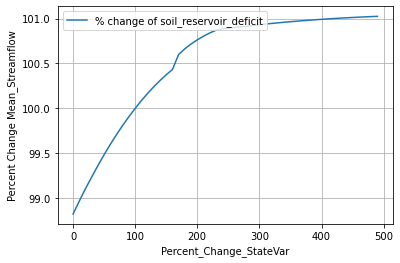

In [7]:
## CFE State vars
no_change = df.loc[df['Percent_Change_StateVar'] == 100]
# # # # # no_change['Sum streamflow']
Q_at_no_change=float(no_change['Mean_Streamflow'])
# # # # # float(Q_at_no_change)
df['Mean_Streamflow']=100*df['Mean_Streamflow']/Q_at_no_change
#print(df)

x = df.iloc[:,1]
y = df.iloc[:,0]
m, b = np.polyfit(x,y,1)
m = round(m, 6)
b = round(b, 6)

print('Percent_Change_StateVar = %s(Percent_Change_Streamflow) + %s' %(m, b))

## CFE Peturbed State vars
no_change_p = df_p.loc[df_p['Percent_Change_StateVar'] == 100]
# # # # # no_change['Sum streamflow']
Q_at_no_change_p = float(no_change_p['Mean_Streamflow'])
# # # # # float(Q_at_no_change)
df_p['Mean_Streamflow']=100*df_p['Mean_Streamflow']/Q_at_no_change_p

x2 = df_p.iloc[:,1]
y2 = df_p.iloc[:,0]
m2, b2 = np.polyfit(x2,y2,1)
m2 = round(m2, 3)
b2 = round(b2, 3)

#print('Percent_Change_StateVar_Peturb = %s(Percent_Change_Streamflow_Peturb) + %s' %(m2, b2))

# # # #df['Sum streamflow'][100]
# # # # df['Sum streamflow']#/Q_at_no_change
plt.plot(df['Percent_Change_StateVar'],df['Mean_Streamflow'],label='% change of soil_reservoir_deficit', color='tab:blue')
#plt.plot(df['Percent_Change_StateVar'],label='% change of soil_reservoir_deficit', color='tab:blue')
#plt.plot(df['Mean_Streamflow'], 'o', label='% change of Q', color = 'tab:orange')
#plt.xticks([])
plt.xlabel('Percent_Change_StateVar')
plt.ylabel('Percent Change Mean_Streamflow')
plt.legend(loc=2)
plt.grid()
print(df)
#print(df_p)


In [8]:
# Find mean streamflow to based changes on
# df_mean = df['Sum_streamflow'].mean()
#print('The Mean streamflow is %s' %(df_mean))

# If statement to add group to assocaited percent range 
df.loc[df['Percentage'] <=0.25,'Group'] = 1
df.loc[(df['Percentage'] > 0.25) & (df['Percentage'] <= 0.5),'Group'] = 2
df.loc[(df['Percentage'] > 0.5) & (df['Percentage'] <= 1.0),'Group'] = 3
df.loc[(df['Percentage'] > 1.0) & (df['Percentage'] <= 1.5),'Group'] = 4
df.loc[(df['Percentage'] > 1.5) & (df['Percentage'] <= 2.0),'Group'] = 5

# Test runoff
runoff_queue_m_per_timestep = 1
df.loc[(df['Group'] == 3), 'runoff_queue_m_per_timestep'] = runoff_queue_m_per_timestep * 0.1
#print(df)

KeyError: 'Percentage'